**Objetivo**

Este notebook tem como objetivo o desenvolvimento de modelos preditivos de machine learning com o objetivo de estimar pressão e temperatura de um gás através de seu respectivo espectro de alta resolução, ou seja, teremos acesso às transições rotacionais.

**Como**


Para cada espectro, iremos separar as raias espectrais e realizar o ajuste das mesmas através do perfil de Voigt.

Os parâmetros obtidos pelo ajuste serão as features que utilizaremos para treinar os modelos. Cada conjunto de parâmetros terá associado uma temperatura e uma pressão.

Utilizaremos os espectros da molécula de ácido clorídrico (HCl) por dois motivos:

1. Temos 14 espectros reais variando em temperatura e pressão.

2. Conseguimos simular esses espectros via HITRAN alterando pressão e temperatura.


Abordaremos duas metodologias:

1. Treinar e testar modelos em espectros simulados e validar em espectros reais

2. Treinar e validar somente em espectros reais.


No treinamento, iremos separar algumas linhas, obteremos os parâmetros de todas e avaliaremos os modelos. Em um teste mais realista, obteremos um espectro, faremos a extração das raias e a obtenção dos parâmetros via ajuste não linear. Para cada linha do espectro, teremos uma estimativa de pressão e temperatura.  Após todas as linhas serem ingeridas no modelo, teremos uma lista com diversas pressões e temperaturas. Essa lista será tratada em um pós-processamento, calcularemos o valor médio ou mediano e em torno desse teremos um intervalo de confiança, essa abordagem será realizada para pressão e temperatura.


**Motivação:**

Gases constituidos por moléculas de HCl são altamente corrosivos.  Ao realizarmos experimentos com esse tipo de gás, grande parte do setup experimental é degradado devido a reatividade desse ácido. A depender do estudo a ser feito, é necessário termos ciência da temperatura e pressão do gás, como exemplo, temos que o alargamento das linhas espectrais está associado à pressão ao qual o gás se encontra. No entanto, equipamentos de medidas como termometros e sensores de pressão não são baratos e perde-los em um experimento envolvendo gases corrosivos não é vantajoso. Desse modo, podemos utilizar aprendizado de maquina para estimar as pressões e temperaturas de nossos gases baseando-nos em seus respectivos espectros.

Muitas vezes é dificil conseguirmos uma quantidade suficiente de espectros, portanto, uma maneira de mitigarmos esse problema é por meio de simulações.

Por esse motivo, teremos duas metodologias. Além de apenas obter uma estimativa de pressão e temperatura, desejamos também saber se é possível utilizarmos espectros simulados para treinar esses modelos e depois aplica-los em situações reais. 



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from utils import *
import shap

import seaborn as sns

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder, PowerTransformer, Normalizer

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RANSACRegressor, TheilSenRegressor, ElasticNet, BayesianRidge, HuberRegressor, SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import RegressorChain, MultiOutputRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from SpectraHitran.SpectraGenerator.spectragenerator import SpectraGenerator
from SpectraHitran.SpectraProcessing.spectraprocessing import branchClassification, plotSpectrum
from SpectraHitran.SpectraFit.spectrafit import multipleLineFit
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

integrar_dados()

HAPI version: 1.2.2.3
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

carregando dados sintéticos e reais (prod)

In [2]:
train = pd.read_csv('../database/lines/lines_train.csv')
test  = pd.read_csv('../database/lines/lines_test.csv')
prod_raw = pd.read_csv('../database/lines/lines_prod.csv')


prod_raw = prod_raw.query('model == "Voigt"').reset_index(drop=True)
prod_raw[['branch', 'isotopo']] =prod_raw["branch"].str.extract(r'^([RP])(\d{2})$')
prod_raw['m'] = prod_raw.apply(lambda x: x['j'] + 1 if x['branch'] == "R" else -1 * x['j'],axis = 1)



train['pressure'] = train['pressure'] * 1013
test['pressure'] = test['pressure'] * 1013

train['temperature'] = train['temperature'] - 273.15
test['temperature'] = test['temperature'] - 273.15
prod_raw['temperature'] = prod_raw['temperature'] - 273.15

train['branch'] = train.apply(lambda x: 'R' if x['center'] > 5665 else 'P', axis = 1)
test['branch'] = test.apply(lambda x: 'R' if x['center'] > 5665 else 'P', axis = 1)

train = r2Filter(train, 0.8)
test = r2Filter(test, 0.8)

In [3]:
#pressoes = prod['pressure'].unique()
#
#for pressao in pressoes:
#    print(pressao)
#    int_max = prod.query(f'pressure == {pressao}')['height'].max()
#    prod.loc[prod['pressure'] == pressao, 'height'] = prod.loc[prod['pressure'] == pressao, 'height'] / int_max

Separando as informações uteis que serão utilizadas na modelagem

In [4]:
train = train[['branch','center','amplitude','sigma','gamma','fwhm', 'temperature', 'pressure', 'height']]
test = test[['branch','center','amplitude','sigma','gamma','fwhm', 'temperature', 'pressure','height']]
prod = prod_raw[['branch','center','amplitude','sigma','gamma','fwhm', 'temperature', 'pressure','height']]

train, test, prod = eng_features(train.copy()), eng_features(test.copy()), eng_features(prod.copy())

X_train = train.drop(columns=['temperature','pressure'])
y_train_temperature = train['temperature']
y_train_pressure = train['pressure']

X_test = test.drop(columns=['temperature','pressure'])
y_test_temperature = test['temperature']
y_test_pressure = test['pressure']

numeric_cols = X_train.select_dtypes(exclude='object').columns
object_cols = X_train.select_dtypes(include='object').columns



definindo os modelos com diferentes estrategias

In [5]:
models = {
    'linear_regression': LinearRegression(),
    #'lasso': Lasso(max_iter = 10000),
    'ridge': Ridge(),
    'knn': KNeighborsRegressor(),
    'random_forest': RandomForestRegressor(random_state = 0, n_jobs=-1),
    'decision_tree': DecisionTreeRegressor(random_state = 0 ),
    #'svm': SVR()),
    'lgbm': LGBMRegressor(force_col_wise=True, verbose = -1,n_estimators=800),
    'xgb': XGBRegressor(),
    #'elastic_net': ElasticNet(),141
    #'bayesian_ridge': BayesianRidge(),
    #'huber': HuberRegressor(),
    #'sgd': SGDRegressor(),
    #'ransac': RANSACRegressor(),
    #'theil_sen': TheilSenRegressor(),
    #'gaussian_process': GaussianProcessRegressor(),
    #'adaboost': AdaBoostRegressor(),
    'extra_trees': ExtraTreesRegressor(n_estimators=800, n_jobs=-1),
    'mlp': MLPRegressor(hidden_layer_sizes= (8,4,4),max_iter = 500000, random_state=42, early_stopping=True, n_iter_no_change=100, verbose=True),    
}

# Metodologia 1

A metodologia 1 consiste em treinar modelos em espectros sintéticos e aplicar em espectros reais. O objetivo é verificar se é possível treinar modelos uteis a partir de espectros simulados.

Vamos treinar 1 modelo por váriavel. Dessa maneira podemos investigar de forma sistematica suas respectivas saídas.

## Modelo para temperatura

In [25]:
numeric_processor = Pipeline(steps = [('scaler', StandardScaler())])
category_processor = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])
processing = ColumnTransformer(transformers = [('numeric_processing', numeric_processor, numeric_cols),
                                                 ('category_processing', category_processor, object_cols)], remainder='passthrough')

preprocessor = Pipeline(steps = [('preprocessor', processing)])


results_baseline = validacaoCruzada(X_train, y_train_temperature, models, preprocessor)


results_baseline.sort_values('mse', ascending = True)

linear_regression
ridge
knn
random_forest
decision_tree
lgbm
xgb
extra_trees
mlp
Iteration 1, loss = 549.40040304
Validation score: -14.501729
Iteration 2, loss = 547.64096822
Validation score: -14.453707
Iteration 3, loss = 545.92463073
Validation score: -14.407365
Iteration 4, loss = 544.28781080
Validation score: -14.362769
Iteration 5, loss = 542.66115986
Validation score: -14.319370
Iteration 6, loss = 541.15344110
Validation score: -14.277399
Iteration 7, loss = 539.67378578
Validation score: -14.237169
Iteration 8, loss = 538.27121815
Validation score: -14.198388
Iteration 9, loss = 536.87886865
Validation score: -14.161067
Iteration 10, loss = 535.55773012
Validation score: -14.124774
Iteration 11, loss = 534.24938156
Validation score: -14.088910
Iteration 12, loss = 532.97875261
Validation score: -14.053917
Iteration 13, loss = 531.75803399
Validation score: -14.019632
Iteration 14, loss = 530.57467641
Validation score: -13.985963
Iteration 15, loss = 529.39555128
Validation s

,model,mae,mse,mape
3,random_forest,5.981068,7.288352,20.859384
7,extra_trees,5.990559,7.355481,20.809839
2,knn,6.457334,7.772514,22.504657
6,xgb,6.385685,7.879396,22.200022
5,lgbm,6.491870,8.084913,22.526692
4,decision_tree,7.498929,9.920934,25.661964
1,ridge,275.637074,3269.520154,906.924763
8,mlp,795.453248,9568.192643,2613.737939
0,linear_regression,6465.250093,78315.359047,21241.948214


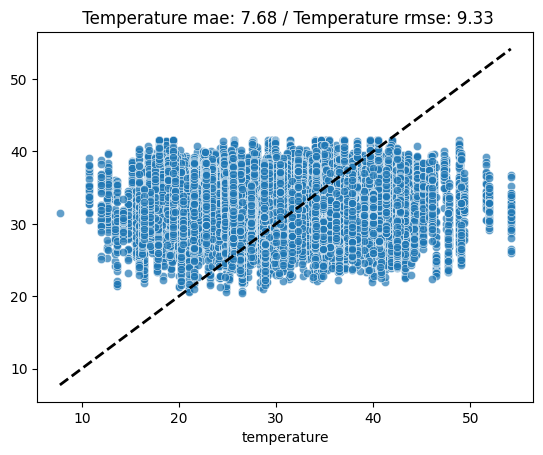

In [26]:
model = RandomForestRegressor(random_state = 0, n_jobs=-1)

numeric_processor = Pipeline(steps = [('scaler', StandardScaler())])
category_processor = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])
processing = ColumnTransformer(transformers = [('numeric_processing', numeric_processor, numeric_cols),
                                               ('category_processing', category_processor, object_cols)],remainder='passthrough')

preprocessor = Pipeline(steps = [('preprocessor', processing)])

step = [('processing', preprocessor),
        ('model', model)
       ]
    
model_pipe = Pipeline(step)

model_pipe.fit(X_train,y_train_temperature)

y_hat = model_pipe.predict(X_test)


plt.title(f" Temperature mae: {mean_absolute_error(y_test_temperature, y_hat):.2f} / Temperature rmse: {root_mean_squared_error(y_test_temperature, y_hat):.2f}" )
sns.scatterplot(x = y_test_temperature, y = y_hat, alpha = 0.7)
plt.plot([y_test_temperature.min(), y_test_temperature.max()], [y_test_temperature.min(), y_test_temperature.max()], 'k--', lw=2)
plt.show()


In [27]:
prod = eng_features(prod_raw.query(' j < 82432')[['branch','center','amplitude','sigma','gamma','fwhm', 'temperature', 'pressure','height']].copy())

real_results_temperatura = {'Temperatura real': [], 'Temperatura estimada': [], 'Diferença absoluta': [], 'Diferença percentual': [],'classe':[]}

temperatures = prod['temperature'].unique()

for temperature in temperatures:
    df_temp = prod.query(f'temperature == {temperature}')
    pressures = df_temp['pressure'].unique()

    for pressure in pressures:
        
        df_pressure = df_temp.query(f'pressure ==  {pressure}')
        df_pressure = df_pressure.drop(['temperature','pressure'],axis=1)
        y_hat = model_pipe.predict(df_pressure)
        temperature_hat = np.mean(y_hat)

        real_results_temperatura['Temperatura real'].append(temperature)
        real_results_temperatura['Temperatura estimada'].append(temperature_hat)
        real_results_temperatura['Diferença absoluta'].append(np.abs(temperature - temperature_hat))
        real_results_temperatura['Diferença percentual'].append((np.abs(temperature - temperature_hat))/temperature*100)
        real_results_temperatura['classe'].append("low" if pressure < 150 else ("medium" if pressure < 400 else "high"))

           

    

results_temperatura = pd.DataFrame(real_results_temperatura)

results_temperatura.round(2).sort_values('Diferença percentual', ascending = False)

,Temperatura real,Temperatura estimada,Diferença absoluta,Diferença percentual,classe
1,20.0,33.35,13.35,66.76,low
3,20.0,31.75,11.75,58.77,high
4,20.0,31.57,11.57,57.84,medium
0,20.0,29.96,9.96,49.80,low
2,20.0,29.81,9.81,49.04,medium
9,42.0,29.34,12.66,30.15,medium
12,42.0,29.48,12.52,29.81,high
10,42.0,29.50,12.50,29.76,medium
11,42.0,30.00,12.00,28.57,medium
5,40.0,29.07,10.93,27.32,low


<Axes: xlabel='Temperatura real', ylabel='Temperatura estimada'>

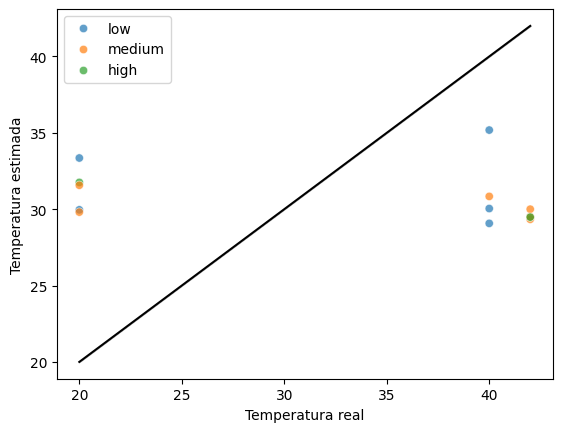

In [10]:
results_temperatura.groupby('classe')[['Diferença absoluta','Diferença percentual']].mean()
sns.scatterplot(data = results_temperatura, x = 'Temperatura real', y = 'Temperatura estimada', alpha = 0.7, hue='classe')
sns.lineplot(x = results_temperatura['Temperatura real'], y = results_temperatura['Temperatura real'], color = 'black')

## Modelo para Pressão

In [11]:
numeric_processor = Pipeline(steps = [('scaler', StandardScaler())])
category_processor = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])
processing = ColumnTransformer(transformers = [('numeric_processing', numeric_processor, numeric_cols),
                                                 ('category_processing', category_processor, object_cols)])

preprocessor = Pipeline(steps = [('preprocessor', processing)])


results_baseline = validacaoCruzada(X_train, y_train_pressure, models, preprocessor)


results_baseline.sort_values('mse', ascending = True)

linear_regression
ridge
knn
random_forest
decision_tree
lgbm
xgb
extra_trees
mlp
Iteration 1, loss = 111971.75665005
Validation score: -2.527928
Iteration 2, loss = 111945.91611645
Validation score: -2.527147
Iteration 3, loss = 111920.79404396
Validation score: -2.526420
Iteration 4, loss = 111897.31733235
Validation score: -2.525723
Iteration 5, loss = 111873.09430939
Validation score: -2.525053
Iteration 6, loss = 111851.25889621
Validation score: -2.524392
Iteration 7, loss = 111829.53519875
Validation score: -2.523744
Iteration 8, loss = 111808.33312440
Validation score: -2.523127
Iteration 9, loss = 111787.19951940
Validation score: -2.522537
Iteration 10, loss = 111767.42972372
Validation score: -2.521951
Iteration 11, loss = 111747.40056344
Validation score: -2.521357
Iteration 12, loss = 111727.49958988
Validation score: -2.520768
Iteration 13, loss = 111707.86477563
Validation score: -2.520167
Iteration 14, loss = 111688.50991686
Validation score: -2.519571
Iteration 15, loss

,model,mae,mse,mape
7,extra_trees,17.300767,2.469204e+01,6.130354
5,lgbm,16.120782,2.606396e+01,5.416116
6,xgb,18.196434,2.972669e+01,5.837248
3,random_forest,20.012070,2.993375e+01,6.631445
4,decision_tree,22.747016,3.959343e+01,7.758851
2,knn,35.743664,5.427323e+01,11.892201
1,ridge,478.031022,5.145121e+03,81.414987
8,mlp,41999.816804,5.086651e+05,5829.677515
0,linear_regression,106886.180472,1.295270e+06,14823.272974


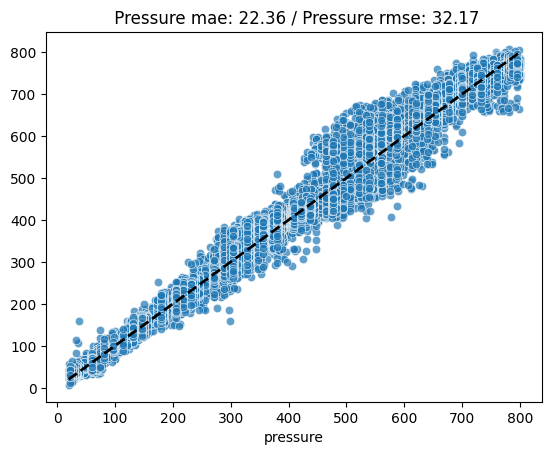

In [ ]:
model = ExtraTreesRegressor(n_estimators=800, n_jobs = -1)

numeric_processor = Pipeline(steps = [('scaler', StandardScaler())])
category_processor = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])
processing = ColumnTransformer(transformers = [('numeric_processing', numeric_processor, numeric_cols),
                                               ('category_processing', category_processor, object_cols)])

preprocessor = Pipeline(steps = [('preprocessor', processing)])

step = [('processing', preprocessor),
        ('model', model)
       ]
    
model_pipe = Pipeline(step)

model_pipe.fit(X_train,y_train_pressure)

y_hat = model_pipe.predict(X_test)


plt.title(f" Pressure mae: {mean_absolute_error(y_test_pressure, y_hat):.2f} / Pressure rmse: {root_mean_squared_error(y_test_pressure, y_hat):.2f}" )
sns.scatterplot(x = y_test_pressure, y = y_hat, alpha = 0.7)
plt.plot([y_test_pressure.min(), y_test_pressure.max()], [y_test_pressure.min(), y_test_pressure.max()], 'k--', lw=2)
plt.show()


In [21]:
prod = eng_features(prod_raw.query(' j < 834')[['branch','center','amplitude','sigma','gamma','fwhm', 'temperature', 'pressure','height']].copy())
real_results_pressure = {'Pressão real': [], 'Pressão estimada': [], 'Diferença absoluta': [], 'Diferença percentual': []}

temperatures = prod['temperature'].unique()

for temperature in temperatures:
    df_temp = prod.query(f'temperature == {temperature}')
    pressures = df_temp['pressure'].unique()

    for pressure in pressures:
        df_pressure = df_temp.query(f'pressure ==  {pressure}')

        y_hat = model_pipe.predict(df_pressure.drop(columns=['temperature','pressure']))

        pressure_hat = np.mean(y_hat)

        real_results_pressure['Pressão real'].append(pressure)
        real_results_pressure['Pressão estimada'].append(pressure_hat)
        real_results_pressure['Diferença absoluta'].append(np.abs(pressure - pressure_hat))
        real_results_pressure['Diferença percentual'].append((np.abs(pressure - pressure_hat))/pressure*100)


           

    

results_pressure = pd.DataFrame(real_results_pressure)
results_pressure['classe'] = results_pressure.apply(lambda x: "low" if x['Pressão real'] < 150 else ("medium" if x['Pressão real'] < 400 else "high") ,axis=1)
results_pressure.round(2).sort_values('Diferença absoluta', ascending = False)

,Pressão real,Pressão estimada,Diferença absoluta,Diferença percentual,classe
7,211.0,370.16,159.16,75.43,medium
3,790.0,675.54,114.46,14.49,high
12,439.0,335.33,103.67,23.61,high
2,200.0,269.42,69.42,34.71,medium
8,76.9,141.13,64.23,83.53,low
6,27.0,75.07,48.07,178.04,low
0,145.0,186.35,41.35,28.52,low
4,398.0,433.35,35.35,8.88,medium
11,218.0,185.80,32.20,14.77,medium
9,181.0,151.44,29.56,16.33,medium


,Diferença absoluta,Diferença percentual
classe,,
high,109.064305,19.051662
low,32.814671,60.233193
medium,58.124592,26.297578


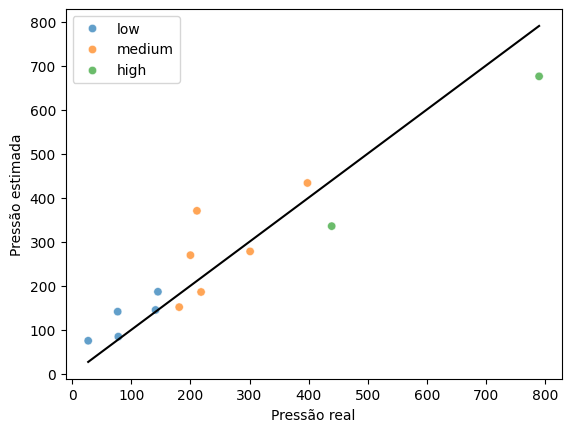

In [22]:
sns.scatterplot(data = results_pressure, x = 'Pressão real', y = 'Pressão estimada', alpha = 0.7, hue='classe')
sns.lineplot(x = results_pressure['Pressão real'], y = results_pressure['Pressão real'], color = 'black')

results_pressure.groupby('classe')[['Diferença absoluta','Diferença percentual']].mean()

In [23]:
results_pressure.describe().T

,count,mean,std,min,25%,50%,75%,max
Pressão real,13.0,246.607692,202.826899,27.000000,141.000000,200.000000,301.000000,790.000000
Pressão estimada,13.0,256.227575,167.295587,75.071468,144.981392,186.347620,335.331409,675.539981
Diferença absoluta,13.0,56.226886,45.456132,3.981392,29.561582,41.347620,69.422061,159.156276
Diferença percentual,13.0,38.234981,49.027998,2.823683,8.882488,16.332366,34.711030,178.042473


# Metodologia 2

Temos 14 espectros em 3 temperaturas diferentes.

Vamos separar alguns desses espectros para treino e outros para avaliação.

Para treino vamos focar nos espectros cujas pressões estão nas extremidades, para assim tentarmos garantir uma maior generalização dentro do intervalo de pressões que temos. Vamos reserver 1 ou 2 espectros por temperatura para avaliação, esses serão os espectros com pressões intermediarias.

In [28]:
prod.groupby('temperature')['pressure'].value_counts().to_frame()

count
temperature pressure       
20.0        145.0        36
            78.0         35
            200.0        34
            398.0        32
            790.0        31
40.0        141.0        31
            211.0        31
            76.9         30
            27.0         28
42.0        439.0        34
            181.0        33
            218.0        33
            301.0        33

In [29]:
pressures_to_test = [200, 141, 301]

test = prod[prod['pressure'].isin(pressures_to_test)]

train = prod[~prod['pressure'].isin(pressures_to_test)]


X_train = train.drop(columns=['temperature','pressure'])
y_train_pressure = train['pressure']
y_train_temperature = train['temperature']

X_test = test.drop(columns=['temperature','pressure'])
y_test_pressure = test['pressure']
y_test_temperature = test['temperature']

Temperature MAE: 3.6524489795918367
Temperature RMSE: 6.251155974730446


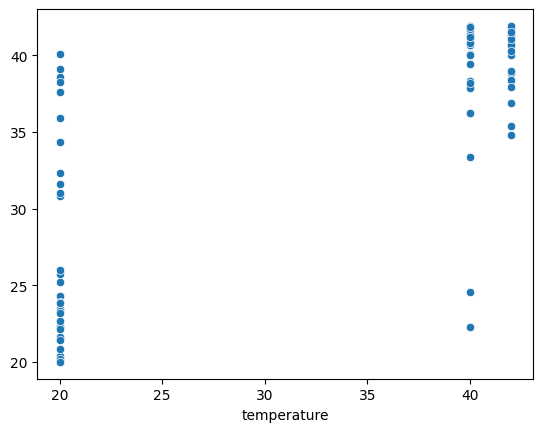

In [30]:
model = RandomForestRegressor(random_state = 0)

numeric_processor = Pipeline(steps = [('scaler', StandardScaler())])
category_processor = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))])
processing = ColumnTransformer(transformers = [('numeric_processing', numeric_processor, numeric_cols),
                                               ('category_processing', category_processor, object_cols)])

preprocessor = Pipeline(steps = [('preprocessor', processing)])

step = [('processing', preprocessor),
        ('model', model)
       ]
    
model_pipe = Pipeline(step)

model_pipe.fit(X_train,y_train_temperature)

y_hat = model_pipe.predict(X_test)


print('Temperature MAE:', mean_absolute_error(y_test_temperature, y_hat))
print('Temperature RMSE:', root_mean_squared_error(y_test_temperature, y_hat))


sns.scatterplot(x = y_test_temperature, y = y_hat)
plt.show()

In [31]:
real_results_temperatura = {'Temperatura real': [], 'Temperatura estimada': [], 'Diferença absoluta': [], 'Diferença percentual': []}
temperatures = prod['temperature'].unique()

for temperature in temperatures:
    df_temp = prod.query(f'temperature == {temperature}')
    pressures = df_temp['pressure'].unique()

    for pressure in pressures:
        df_pressure = df_temp.query(f'pressure ==  {pressure}')

        y_hat = model_pipe.predict(df_pressure.drop(columns=['temperature','pressure']))

        temperature_hat = np.mean(y_hat)

        real_results_temperatura['Temperatura real'].append(temperature)
        real_results_temperatura['Temperatura estimada'].append(temperature_hat)
        real_results_temperatura['Diferença absoluta'].append(np.abs(temperature - temperature_hat))
        real_results_temperatura['Diferença percentual'].append((np.abs(temperature - temperature_hat))/temperature*100)

        
real_results_temperatura = pd.DataFrame(real_results_temperatura)
real_results_temperatura

,Temperatura real,Temperatura estimada,Diferença absoluta,Diferença percentual
0,20.0,21.490556,1.490556,7.452778
1,20.0,20.593714,0.593714,2.968571
2,20.0,26.587647,6.587647,32.938235
3,20.0,20.287097,0.287097,1.435484
4,20.0,20.734375,0.734375,3.671875
5,40.0,39.052258,0.947742,2.369355
6,40.0,40.008571,0.008571,0.021429
7,40.0,39.375484,0.624516,1.561290
8,40.0,39.228667,0.771333,1.928333
9,42.0,41.107879,0.892121,2.124098


In [32]:
real_results_temperatura.iloc[[2,5,10],:]

,Temperatura real,Temperatura estimada,Diferença absoluta,Diferença percentual
2,20.0,26.587647,6.587647,32.938235
5,40.0,39.052258,0.947742,2.369355
10,42.0,40.417576,1.582424,3.767677


# Comparação entre features de produção e simulação

In [33]:
prod.groupby('temperature')['pressure'].value_counts().to_frame()

count
temperature pressure       
20.0        145.0        36
            78.0         35
            200.0        34
            398.0        32
            790.0        31
40.0        141.0        31
            211.0        31
            76.9         30
            27.0         28
42.0        439.0        34
            181.0        33
            218.0        33
            301.0        33

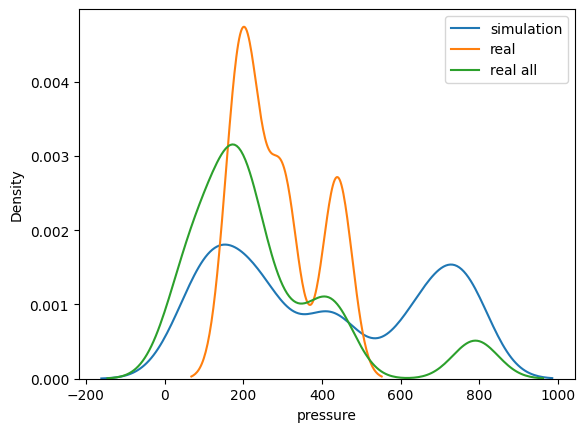

In [18]:
sns.kdeplot(data = train, x='pressure',label='simulation')
sns.kdeplot(data = prod.query('temperature == 42'),  x='pressure',label='real')
sns.kdeplot(data = prod,  x='pressure',label='real all')
plt.legend()

In [104]:
prod

,branch,center,amplitude,sigma,gamma,fwhm,temperature,pressure,gamma_sigma_ratio,amplitude_sigma_ratio,amplitude_gamma_ratio,sigma_plus_gamma,sigma_gamma_interaction,amplitude_fwhm_interaction,sigma2,gamma2,ratio_lg
0,R,5683.566427,0.092382,0.004739,0.033105,0.068169,20.0,145.0,6.986300,19.495743,2.790568,0.037844,0.000157,0.006298,0.000022,0.001096,0.874786
1,R,5701.982114,0.149567,0.005280,0.037694,0.077525,20.0,145.0,7.138627,28.325993,3.967989,0.042974,0.000199,0.011595,0.000028,0.001421,0.877129
2,R,5719.167044,0.173023,0.004839,0.039601,0.080923,20.0,145.0,8.184118,35.757715,4.369159,0.044440,0.000192,0.014001,0.000023,0.001568,0.891116
3,R,5735.107073,0.169962,0.005394,0.038495,0.079175,20.0,145.0,7.136857,31.510350,4.415158,0.043889,0.000208,0.013457,0.000029,0.001482,0.877102
4,R,5749.791425,0.144028,0.004263,0.034073,0.069696,20.0,145.0,7.992199,33.783783,4.227095,0.038336,0.000145,0.010038,0.000018,0.001161,0.888792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,P,5551.720897,0.455149,0.014436,0.062852,0.134863,42.0,439.0,4.353755,31.528347,7.241645,0.077288,0.000907,0.061383,0.000208,0.003950,0.813215
417,P,5524.983031,0.308927,0.011214,0.054030,0.114572,42.0,439.0,4.817970,27.547775,5.717714,0.065244,0.000606,0.035394,0.000126,0.002919,0.828119
418,P,5497.116008,0.182966,0.013069,0.044435,0.099063,42.0,439.0,3.400121,14.000338,4.117600,0.057504,0.000581,0.018125,0.000171,0.001974,0.772734
419,P,5468.128298,0.095572,0.013861,0.035601,0.084577,42.0,439.0,2.568487,6.895207,2.684540,0.049462,0.000493,0.008083,0.000192,0.001267,0.719769


In [ ]:
train.query('temperature >= 39 and temperature <=41')['pressure'].describe()

In [ ]:
s = train.query('temperature >= 39 and temperature <=41').query('pressure > 135 and pressure <= 140')
r = prod.query('temperature == 40 and pressure == 141')

sns.kdeplot(data = s, x='sigma',label='simulation')
sns.kdeplot(data = r, x='sigma',label='real')
plt.legend()

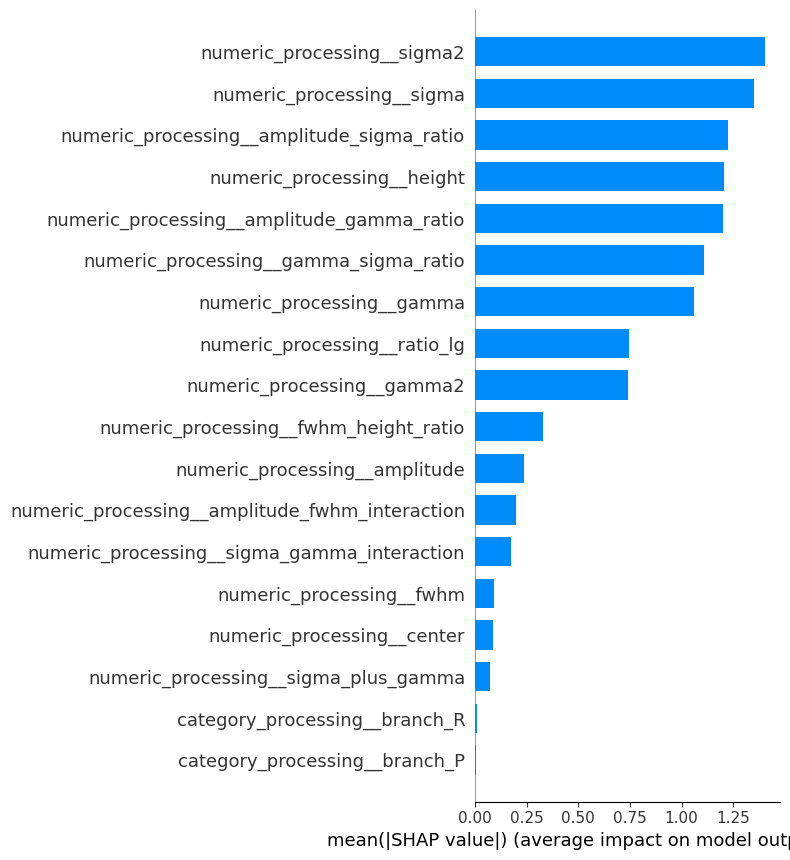

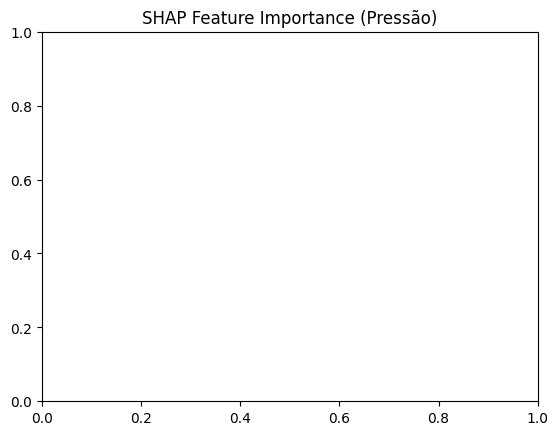

In [35]:
# Extrair o modelo treinado da pipeline
model_fitted = model_pipe.named_steps['model']

# Extrair o pré-processador da pipeline
preprocessor = model_pipe.named_steps['processing']

X_shap = X_train.iloc[:1000,:].copy()
# Pré-processar os dados de treino (X_train deve ser um DataFrame)
X_train_processed = preprocessor.transform(X_shap)

# --------------------------------------------
# Passo 2: Calcular SHAP values para o modelo ExtraTreesRegressor
# --------------------------------------------
# Inicializar o explainer com o modelo treinado
explainer = shap.TreeExplainer(model_fitted)

# Calcular SHAP values para os dados pré-processados 
shap_values = explainer.shap_values(X_train_processed)

# --------------------------------------------
# Passo 3: Visualização (exemplo para pressão)
# --------------------------------------------
# Obter nomes das features após pré-processamento
# (Atenção: OneHotEncoder cria novas colunas para categorias!)
feature_names = preprocessor.get_feature_names_out()

# Plotar summary plot
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_train_processed, feature_names=feature_names, plot_type="bar")
plt.title("SHAP Feature Importance (Pressão)")
plt.show()

In [ ]:
X_shap